In [1]:
import utils
# from utils import DeltaEnsemble
from mnist_models import TwoLayerNN, MLP, CNN, MLPBN, ConvNet, LeNet, LeNet5
import torch.nn.functional as F

import torch

m = CNN()
batchSize = 1000
loss_fn = lambda x, y: F.nll_loss(torch.log(x + 1e-9), y)
learningRate = 0.001

optimizer = torch.optim.Adam(m.parameters(), lr = learningRate)

num_epochs = 5

utils.train_model(m, loss_fn, batchSize, utils.trainset, utils.valset, optimizer, num_epochs)


Validation-epoch 0. Avg-Loss: 0.3369, Accuracy: 0.9192
Validation-epoch 1. Avg-Loss: 0.1316, Accuracy: 0.9673
Validation-epoch 2. Avg-Loss: 0.0707, Accuracy: 0.9813
Validation-epoch 3. Avg-Loss: 0.0516, Accuracy: 0.9856
Validation-epoch 4. Avg-Loss: 0.0427, Accuracy: 0.9872


In [2]:
utils.attack_model(m, loss_fn, 1000, utils.valset, 400);


Before. Avg-Loss: 0.0427, Accuracy: 0.9872
After. Avg-Loss: 1.2628, Accuracy: 0.5835


In [52]:
import numpy as np

class DeltaEnsemble(torch.nn.Module):
    def __init__(self, m, eps = 0.1, n_neighb = 0):
        super(DeltaEnsemble, self).__init__()
        self.m = m
        self.eps = eps
        self.n_neighb = n_neighb

    def _get_neighb_steep(self, x, n_neighb):
        all_inputs = [x]
        for k in range(n_neighb):
            grad = torch.sigmoid(torch.rand_like(x).uniform_(-200, 200))
            ub = torch.clamp(x + self.eps, min = 0, max = 1)
            lb = torch.clamp(x - self.eps, min = 0, max = 1)
            delta = ub - lb
            x2 = delta * grad + lb
            all_inputs.append(x2)
        return torch.stack(all_inputs)

    def _cam_z(self, x):
        x_ = x.clone().detach()
        x_.requires_grad = True
        z_ = self.m._feature(x_)
        z = z_.detach()
        z = z +  torch.randn_like(z).normal_(std = z.std() / 10)
        loss_z = F.mse_loss(z_, z)
        loss_z.backward()
        return x_.grad

    def _cam_d(self, x):
        x_ = x.clone().detach()
        x_.requires_grad = True
        d_ = self.m(x_)
        d = torch.rand_like(d_).uniform_(-100, 100).softmax(-1)
        loss_d = F.kl_div(d_.log(), d)
        loss_d.backward()
        return x_.grad

    def _get_neighb_with_cam(self, x, n_neighb):
        cam_abs = self._cam_z(x).abs()
        cam_mask = cam_abs > np.percentile(cam_abs.cpu(), 75)

        x = x.unsqueeze(0)
        x_ = x.repeat(n_neighb, 1, 1, 1, 1)
        x_ = x + torch.randn_like(x_).sign() * self.eps * cam_mask
        x_ = torch.clamp(x_, min = 0, max = 1)
        x_ = torch.cat((x, x_), dim = 0)
        return x_

    def _get_neighb_uniform(self, x, n_neighb):
        x = x.unsqueeze(0)
        x_ = x.repeat(n_neighb, 1, 1, 1, 1)
        ub = torch.clamp(x + self.eps, min = 0, max = 1)
        lb = torch.clamp(x - self.eps, min = 0, max = 1)
        x_ = (ub - lb) * torch.rand_like(x_) + lb
        x_ = torch.cat((x, x_), dim = 0)
        return x_

    def _predict_neighb(self, x, n_neighb):
        all_inputs = self._get_neighb_uniform(x, n_neighb)
        if (n_neighb + 1) * len(x) <= 10000:
            outputs = self.m(all_inputs.view((n_neighb + 1) * len(x), *x.shape[1:])).view((n_neighb + 1), len(x), -1)
        else:
            outputs = torch.stack([self.m(i) for i in all_inputs])
        return outputs

    def forward(self, x, n_neighb = -1):
        if n_neighb == -1:
            n_neighb = self.n_neighb

        if n_neighb == 0:
            return self.m(x)
        else:            
            outputs = self._predict_neighb(x, n_neighb)
            return sum(outputs) / n_neighb

In [67]:
for i in [1, 2, 5, 10]:
    print(i)
    m_ = DeltaEnsemble(m, n_neighb = i, eps = 0.6)
    m_.eval()
    utils.attack_model(m_, loss_fn, int(40000 // max(1, i)), utils.valset, 400)
#     break

1
Before. Avg-Loss: -0.2675, Accuracy: 0.9643
After. Avg-Loss: 0.7945, Accuracy: 0.3964
2
Before. Avg-Loss: 0.2148, Accuracy: 0.6176
After. Avg-Loss: 1.2952, Accuracy: 0.1915
5
Before. Avg-Loss: 0.6928, Accuracy: 0.4816
After. Avg-Loss: 1.8104, Accuracy: 0.1207
10
Before. Avg-Loss: 0.9722, Accuracy: 0.4478
After. Avg-Loss: 2.2220, Accuracy: 0.1073


In [68]:
m_ = DeltaEnsemble(m, n_neighb = 10)

import matplotlib.pyplot as plt
import torchattacks
atk = torchattacks.PGD(m_, eps=0.1, alpha=1/255, steps=400, random_start=False)


In [69]:
from tqdm.notebook import tqdm
wrong = []

for k, (x, label) in enumerate(tqdm(utils.valset)):
    m_.eval()
    x = x.unsqueeze(0).cuda()    
    adv_images = atk(x, torch.tensor(label).unsqueeze(0).cuda())    
    if m_(x).argmax().item() != m_(adv_images).argmax().item():
        wrong.append(k)
        break

  0%|          | 0/10000 [00:00<?, ?it/s]

In [70]:
# k = 35
x, label = utils.valset[k]
x = x.unsqueeze(0).cuda()
adv_images = atk(x, torch.tensor(label).unsqueeze(0).cuda())


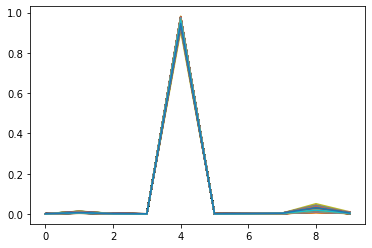

In [71]:
x_ = m_._get_neighb_uniform(x, 1000)
pred_ = m(x_.squeeze(1))
plt.plot(pred_.cpu().detach().T)
plt.show()

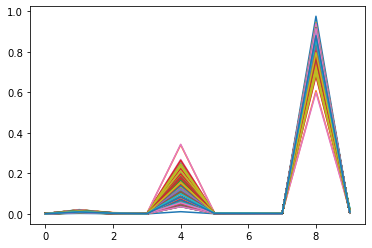

Counter({4: 1001})
Counter({8: 1001})


In [72]:
adv_images_ = m_._get_neighb_uniform(adv_images, 1000)
pred_adv_images_ = m(adv_images_.squeeze(1))
plt.plot(pred_adv_images_.cpu().detach().T)
plt.show()

from collections import Counter

print(Counter(pred_.cpu().detach().argmax(1).tolist()))
print(Counter(pred_adv_images_.cpu().detach().argmax(1).tolist()))


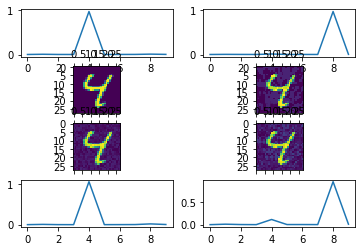

In [73]:
import random

fig, axs = plt.subplots(4, 2)
axs[0, 0].plot(m(x.repeat(2, 1,1,1)).tolist()[0])
axs[0, 1].plot(m(adv_images.repeat(2, 1,1,1)).tolist()[0])
axs[1, 0].matshow(x.squeeze().cpu())
axs[1, 1].matshow(adv_images.squeeze().cpu())
axs[2, 0].matshow(x_[random.randint(0, len(adv_images_))].squeeze().cpu())
axs[2, 1].matshow(adv_images_[random.randint(0, len(adv_images_))].squeeze().cpu())
axs[3, 0].plot(m_(x.repeat(2, 1,1,1)).tolist()[0])
axs[3, 1].plot(m_(adv_images.repeat(2, 1,1,1)).tolist()[0])
